In [9]:
# Run python file Create_Val_Test_Train.py to create the dataset

## Model 1

In [2]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


df_train = np.load('df_train.npy')
df_validation = np.load('df_validation.npy')
df_test = np.load('df_test.npy')
# restore np.load for future normal usage
np.load = np_load_old
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch.utils.data import Dataset
torch.manual_seed(42)
np.random.seed(42)
# Define your custom dataset
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

X_train = df_train[:,3]
y_train = df_train[:,2]
# Create dataset
train_dataset = MyDataset(X_train, y_train)
# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
del X_train
X_test = df_test[:,3]
y_test = df_test[:,2]
X_val = df_validation[:,3]
y_val = df_validation[:,2]
val_dataset = MyDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
testloader = torch.utils.data.DataLoader(X_test, batch_size=32)

In [3]:
# Simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(65, 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*240, 65) 
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer
        self.fc3 = nn.Linear(65, 2)
        

    def forward(self, x):
        x = x.view(-1, 65, 256, 240)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
# Initialize the network and print its architecture
model = Net()
print(model)

Net(
  (conv1): Conv2d(65, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=30720, out_features=65, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=65, out_features=2, bias=True)
)


In [4]:
torch.manual_seed(42)
np.random.seed(42)
from torch.optim.lr_scheduler import StepLR

# Initialize the network and print its architecture
model = Net()
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.5,1.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize empty lists to store losses
train_losses = []

# Training loop
for epoch in range(15):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()
        labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        l1_lambda = 0.0005
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(outputs, labels)
        loss+=l1_lambda*l1_norm
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Compute training loss
        train_losses.append(loss.item())

    scheduler.step()
    print(f'Epoch {epoch+1}, training loss: {running_loss/len(train_dataloader):.4f}')

# Now without regularization
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# Training loop
for epoch in range(15):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()
        labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Compute training loss
        train_losses.append(loss.item())
    print(f'Epoch {epoch+1}, training loss: {running_loss/len(train_dataloader):.4f}')

print('Finished Training')

KeyboardInterrupt: 

In [ ]:

from sklearn.metrics import confusion_matrix


def find_optimal_threshold(predictions, y_test):
    min_sum = float('inf')
    optimal_threshold = 0.5
    # Iterate over possible thresholds from 0 to 1
    for threshold in np.arange(0.3, 0.8, 0.001):
        # Apply threshold
        preds = (np.array(predictions)[:,1] > threshold).astype(int)
        # Compute confusion matrix
        cm = confusion_matrix(y_test, preds)
        # Compute sum of off-diagonal elements
        off_diagonal_sum = 164 - np.trace(cm)
        # Update optimal threshold if this threshold is better
        if off_diagonal_sum < min_sum and cm[1][1]/np.sum(cm[1]) >=0.5:
            min_sum = off_diagonal_sum
            optimal_threshold = threshold

    return optimal_threshold
model.eval()  # Set the model to evaluation mode
predictions = []
output = []
with torch.no_grad():
    for data in valloader:
        outputs = model(data[0].float().to(device)).to(device)
        predicted = torch.softmax(outputs, dim = 1) # Apply a threshold
        predictions.extend(predicted.tolist())
        output.extend(outputs.tolist())

        
optimal_threshold = find_optimal_threshold(predictions, y_val.astype(int))
# Calculate the confusion matrix
mcm = confusion_matrix(y_val.astype(int), (np.array(predictions)[:,1]>optimal_threshold).astype(int))

print('Confusion Matrix:')
for i, matrix in enumerate(mcm):
    print(f'Class {i}:')
    print(matrix)


predictions = []
output = []
with torch.no_grad():
    for data in testloader:
        outputs = model(data.float().to(device)).to(device)
        predicted = torch.softmax(outputs, dim = 1) # Apply a threshold
        predictions.extend(predicted.tolist())
        output.extend(outputs.tolist())
# Calculate the confusion matrix
mcm = confusion_matrix(y_test.astype(int), (np.array(predictions)[:,1]>optimal_threshold).astype(int))

print('Confusion Matrix:')
for i, matrix in enumerate(mcm):
    print(f'Class {i}:')
    print(matrix)

In [ ]:

from sklearn.metrics import roc_auc_score

# Convert tensors to numpy arrays for sklearn
outputs_np = (np.array(predictions)[:,1]>optimal_threshold).astype(int)
labels_np = y_test.astype(int)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
# Calculate and print the accuracy of the model
accuracy = accuracy_score(labels_np, outputs_np)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate and print the ROC AUC score
print("ROC AUC score:", roc_auc_score(labels_np, outputs_np))

# Calculate and print the confusion matrix
print("Confusion matrix:\n", confusion_matrix(labels_np, outputs_np))

# Calculate precision, recall, F1 score
precision, recall, fscore, _ = score(labels_np, outputs_np)
print("Precision, Recall, Fscore:", precision, recall, fscore)

In [ ]:
optimal_threshold

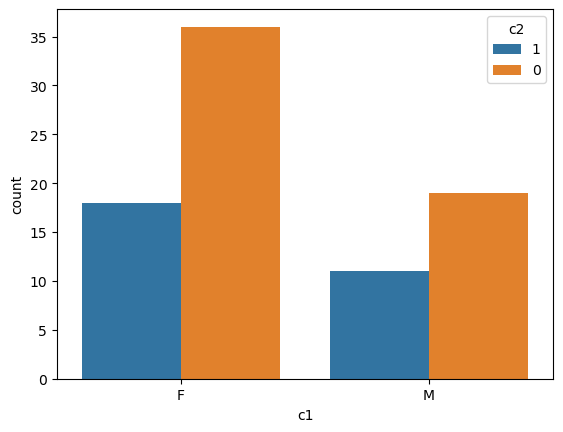

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppose this is your DataFrame
df = pd.DataFrame({
    'c1': df_test[:,0],  
    'c2': outputs_np 
})
# Convert 'c2' column to string type
df['c2'] = df['c2'].astype(str)
# Create a countplot
sns.countplot(x='c1', hue='c2', data=df)

# Show the plot
plt.show()

In [7]:
# MCI vs CN -- ADNI dataset

In [8]:
# Get the probability output and then add two features to xgboost model and try

## Model 2

### Data Prep for model 2. Can be skipped

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch.utils.data import Dataset
class MyModel(nn.Module):
    def __init__(self, original_model):
        super(MyModel, self).__init__()
        self.conv1 = original_model.conv1
        self.fc1 = original_model.fc1

    def forward(self, x):
        x = x.view(-1, 65, 256, 240)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.relu(self.fc1(x))
        return x

# Create the new model
new_model = MyModel(model)

In [10]:
outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_train = []
for data in train_dataloader:
    input_data = data[0].float()
    labels_train.append(data[1])
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
flattened_labels = np.concatenate(labels_train, axis = 0)
del outputs, output
np.save('vectorized_train.npy', flattened_outputs)
np.save('vectorized_tr_labels.npy', flattened_labels)

outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_val = []
for data in valloader:
    input_data = data[0].float()
    labels_val.append(data[1])
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
flattened_labels = np.concatenate(labels_val, axis = 0)
del outputs, output
np.save('vectorized_val.npy', flattened_outputs)
np.save('vectorized_val_labels.npy', flattened_labels)

outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_train = []
for data in testloader:
    input_data = data.float()
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
del outputs, output
np.save('vectorized_test.npy', flattened_outputs)
np.save('y_test.npy', y_test.astype(int))

### This is the second model. Run from here

In [5]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [6]:
X_train = np.load('vectorized_train.npy')
y_train = np.load('vectorized_tr_labels.npy')
X_val = np.load('vectorized_val.npy')
y_val = np.load('vectorized_val_labels.npy')
X_test = np.load('vectorized_test.npy')
y_test = np.load('y_test.npy')
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


df_train = np.load('df_train.npy')
df_validation = np.load('df_validation.npy')
df_test = np.load('df_test.npy')
# restore np.load for future normal usage
np.load = np_load_old
# Convert the 'sex' column from string to int
df_train[:,0] = (df_train[:,0]=='M').astype(int)
df_validation[:,0] = (df_validation[:,0]=='M').astype(int)
df_test[:,0] = (df_test[:,0]=='M').astype(int)
# Add the 'sex' and 'age' columns to your X_train and X_val
X_train = np.hstack((X_train, df_train[:,0:2]))
X_val = np.hstack((X_val, df_validation[:,0:2]))
X_test = np.hstack((X_test, df_test[:,0:2]))

In [7]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
# Your data and labels
data = np.vstack((X_train,X_val))
labels = np.hstack((y_train,y_val))

# Split the data into training and testing sets first
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

scale_pos_weight = sum(labels_train == 0) / sum(labels_train == 1)

# Define the XGBoost model
model = XGBClassifier(
    objective='binary:logistic',  # Objective function for binary classification
    scale_pos_weight = scale_pos_weight,
    random_state=42  # Random seed
)

# Define the parameter grid for RandomSearch
param_grid = {
    'max_depth': [2, 3, 5],  # Maximum depth of the trees
    'learning_rate': [0.001, 0.005, 0.01],  # Learning rate (eta)
    'n_estimators': [50, 75, 100]  # Number of training rounds
}

# Initialize RandomSearch
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)

# Perform RandomSearch
random_search.fit(data_train, labels_train)

# Print the best parameters found
print(random_search.best_params_)

# Train the model with early stopping using the best found parameters
model = random_search.best_estimator_
eval_set = [(data_test, labels_test)]  # Validation set for early stopping
model.fit(data_train, labels_train, eval_metric="logloss", eval_set=eval_set)

# Make predictions on the test set
preds_prob = model.predict_proba(data_test)


C:\Users\thetu\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}
[0]	validation_0-logloss:0.68638
[1]	validation_0-logloss:0.68015
[2]	validation_0-logloss:0.67383
[3]	validation_0-logloss:0.66776
[4]	validation_0-logloss:0.66166
[5]	validation_0-logloss:0.65558
[6]	validation_0-logloss:0.64983
[7]	validation_0-logloss:0.64379
[8]	validation_0-logloss:0.63798
[9]	validation_0-logloss:0.63246
[10]	validation_0-logloss:0.62688
[11]	validation_0-logloss:0.62142
[12]	validation_0-logloss:0.61639
[13]	validation_0-logloss:0.61130
[14]	validation_0-logloss:0.60652
[15]	validation_0-logloss:0.60145
[16]	validation_0-logloss:0.59659
[17]	validation_0-logloss:0.59195
[18]	validation_0-logloss:0.58733
[19]	validation_0-logloss:0.58256
[20]	validation_0-logloss:0.57843
[21]	validation_0-logloss:0.57383
[22]	validation_0-logloss:0.56951
[23]	validation_0-logloss:0.56510
[24]	validation_0-logloss:0.56109
[25]	validation_0-logloss:0.55700
[26

C:\Users\thetu\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-logloss:0.50676
[40]	validation_0-logloss:0.50388
[41]	validation_0-logloss:0.50066
[42]	validation_0-logloss:0.49776
[43]	validation_0-logloss:0.49483
[44]	validation_0-logloss:0.49196
[45]	validation_0-logloss:0.48887
[46]	validation_0-logloss:0.48638
[47]	validation_0-logloss:0.48347
[48]	validation_0-logloss:0.48081
[49]	validation_0-logloss:0.47822
[50]	validation_0-logloss:0.47539
[51]	validation_0-logloss:0.47304
[52]	validation_0-logloss:0.47031
[53]	validation_0-logloss:0.46807
[54]	validation_0-logloss:0.46539
[55]	validation_0-logloss:0.46297
[56]	validation_0-logloss:0.46067
[57]	validation_0-logloss:0.45830
[58]	validation_0-logloss:0.45604
[59]	validation_0-logloss:0.45384
[60]	validation_0-logloss:0.45142
[61]	validation_0-logloss:0.44928
[62]	validation_0-logloss:0.44716
[63]	validation_0-logloss:0.44494
[64]	validation_0-logloss:0.44308
[65]	validation_0-logloss:0.44085
[66]	validation_0-logloss:0.43895
[67]	validation_0-logloss:0.43702
[68]	validatio

In [8]:
from sklearn.metrics import confusion_matrix
# Make predictions on the test set
def find_optimal_threshold(predictions, y_test):
    min_sum = float('inf')
    optimal_threshold = 0.5

    # Iterate over possible thresholds from 0 to 1
    for threshold in np.arange(0.3, 0.8, 0.001):
        # Apply threshold
        preds = (np.array(predictions)[:,1] > threshold).astype(int)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, preds)

        # Compute sum of off-diagonal elements
        off_diagonal_sum = 164 - np.trace(cm)
        #print(cm)
        # Update optimal threshold if this threshold is better
        if off_diagonal_sum < min_sum and cm[1][1]/np.sum(cm[1]) >0.5:
            min_sum = off_diagonal_sum
            optimal_threshold = threshold

    return optimal_threshold

threshold = find_optimal_threshold(preds_prob, labels_test)
preds = (preds_prob[:, 1]> threshold).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(labels_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.41%


In [9]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels_test, preds)

0.8700607902735563

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_test, preds)

array([[83, 11],
       [ 7, 42]], dtype=int64)

In [11]:
from sklearn.metrics import precision_recall_fscore_support as score
# Calculate precision, recall, F1 score
precision, recall, fscore, _ = score(labels_test, preds)
precision, recall, fscore

(array([0.92222222, 0.79245283]),
 array([0.88297872, 0.85714286]),
 array([0.90217391, 0.82352941]))

In [12]:
threshold

0.338

In [13]:
pred_test = model.predict_proba(X_test)
preds = (pred_test[:, 1]> threshold).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
roc_auc_score(y_test, preds)

Accuracy: 63.10%


0.6071211199026172

In [14]:
confusion_matrix(y_test, preds)

array([[37, 16],
       [15, 16]], dtype=int64)

In [15]:
# Calculate precision, recall, F1 score
precision, recall, fscore, _ = score(y_test, preds)
precision, recall, fscore

(array([0.71153846, 0.5       ]),
 array([0.69811321, 0.51612903]),
 array([0.7047619 , 0.50793651]))

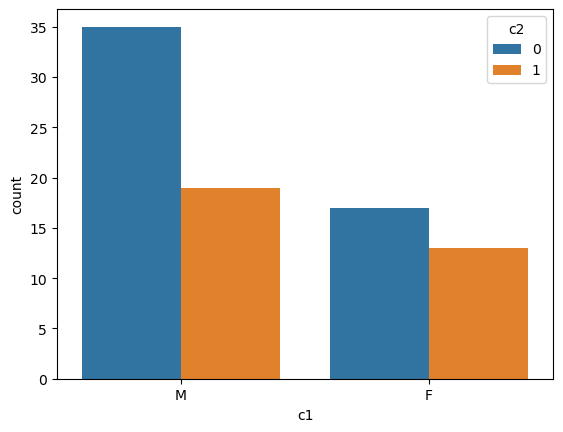

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create the dataframe
df = pd.DataFrame({
    'c1': df_test[:,0],  
    'c2': preds 
})
# Convert 'c2' column to string type
df['c2'] = df['c2'].astype(str)
# Create a countplot
sns.countplot(x='c1', hue='c2', data=df)
# Replace the x-axis labels
plt.xticks([0, 1], ['M', 'F'])

# Show the plot
plt.show()

## Model 3

### Data prep

In [81]:
# Import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)
np.random.seed(42)

# Define your custom dataset
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# Simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(65, 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*240, 65) 
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer
        self.fc3 = nn.Linear(65, 2)

    def forward(self, x):
        x = x.view(-1, 65, 256, 240)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
# Initialize the network and print its architecture
model = Net()

In [82]:

# Extract the features and labels from the training data
X_train = df_train[:,3]
y_train = df_train[:,2]

# Create a dataset from the training data
train_dataset = MyDataset(X_train, y_train)

# Create a DataLoader for the training data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Delete the original training features to save memory
del X_train

# Extract the features and labels from the test and validation data
X_test = df_test[:,3]
y_test = df_test[:,2]
X_val = df_validation[:,3]
y_val = df_validation[:,2]

# Create datasets from the validation and test data
val_dataset = MyDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
testloader = torch.utils.data.DataLoader(X_test, batch_size=32)

# Initialize the network
model = Net()
torch.manual_seed(42)
np.random.seed(42)
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.5,1.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize a list to store the training losses
train_losses = []

# Training loop
for epoch in range(15):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs and labels from the current batch of data
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()  # Convert the inputs to float
        labels = labels.type(torch.LongTensor)   # Cast the labels to long
        inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the L1 norm of the model parameters
        l1_lambda = 0.0005
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        # Compute the loss
        loss = criterion(outputs, labels)
        loss += l1_lambda * l1_norm  # Add the L1 regularization term to the loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Store the loss for this batch
        train_losses.append(loss.item())

    scheduler.step()
    # Print the average training loss for this epoch
    print(f'Epoch {epoch+1}, training loss: {running_loss/len(train_dataloader):.4f}')

# Now train the model without L1 regularization
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Training loop
for epoch in range(15):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs and labels from the current batch of data
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()  # Convert the inputs to float
        labels = labels.type(torch.LongTensor)   # Cast the labels to long
        inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Store the loss for this batch
        train_losses.append(loss.item())

    # Print the average training loss for this epoch
    print(f'Epoch {epoch+1}, training loss: {running_loss/len(train_dataloader):.4f}')

Epoch 1, training loss: 3.1844
Epoch 2, training loss: 2.3908
Epoch 3, training loss: 1.7668
Epoch 4, training loss: 1.3303
Epoch 5, training loss: 1.0994
Epoch 6, training loss: 0.9849
Epoch 7, training loss: 0.9217
Epoch 8, training loss: 0.8837
Epoch 9, training loss: 0.8588
Epoch 10, training loss: 0.8528
Epoch 11, training loss: 0.8119
Epoch 12, training loss: 0.8082
Epoch 13, training loss: 0.7965
Epoch 14, training loss: 0.7730
Epoch 15, training loss: 0.7882
Epoch 1, training loss: 0.6745
Epoch 2, training loss: 0.6380
Epoch 3, training loss: 0.5317
Epoch 4, training loss: 0.4831
Epoch 5, training loss: 0.3654
Epoch 6, training loss: 0.3228
Epoch 7, training loss: 0.2624
Epoch 8, training loss: 0.2085
Epoch 9, training loss: 0.2725
Epoch 10, training loss: 0.2122
Epoch 11, training loss: 0.1887
Epoch 12, training loss: 0.1904
Epoch 13, training loss: 0.2461
Epoch 14, training loss: 0.1369
Epoch 15, training loss: 0.1002


In [85]:
# Get the probability outputs
class MyModel(nn.Module):
    def __init__(self, original_model):
        super(MyModel, self).__init__()
        self.conv1 = original_model.conv1
        self.fc1 = original_model.fc1
        self.dropout = original_model.dropout
        self.fc3 = original_model.fc3

    def forward(self, x):
        x = x.view(-1, 65, 256, 240)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create the new model
new_model = MyModel(model)

In [88]:
outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_train = []
for data in train_dataloader:
    input_data = data[0].float()
    labels_train.append(data[1])
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
flattened_labels = np.concatenate(labels_train, axis = 0)
del outputs, output
np.save('probs_train.npy', flattened_outputs)
np.save('tr_labels.npy', flattened_labels)

outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_val = []
for data in valloader:
    input_data = data[0].float()
    labels_val.append(data[1])
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
flattened_labels = np.concatenate(labels_val, axis = 0)
del outputs, output
np.save('probs_val.npy', flattened_outputs)
np.save('val_labels.npy', flattened_labels)

outputs = [] #stores one feature/value for each image for each patient.  Shape is (*,65).
labels_train = []
for data in testloader:
    input_data = data.float()
    output = new_model(input_data.to(device))
    outputs.append(output.detach().cpu().numpy()) 
flattened_outputs = np.concatenate(outputs, axis=0)
del outputs, output
np.save('probs_test.npy', flattened_outputs)
np.save('y_test.npy', y_test.astype(int))

### Model 3 starts here

In [1]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Load the training data
X_train = np.load('probs_train.npy')
y_train = np.load('tr_labels.npy')

# Load the validation data
X_val = np.load('probs_val.npy')
y_val = np.load('val_labels.npy')

# Load the test data
X_test = np.load('probs_test.npy')
y_test = np.load('y_test.npy')

# Save the original np.load function
np_load_old = np.load

# Modify the default parameters of np.load to allow loading pickled data
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Load the additional dataframes
df_train = np.load('df_train.npy')
df_validation = np.load('df_validation.npy')
df_test = np.load('df_test.npy')

# Restore np.load for future normal usage
np.load = np_load_old

# Convert the 'sex' column from string to int
# 'M' is converted to 1 and 'F' is converted to 0
df_train[:,0] = (df_train[:,0]=='M').astype(int)
df_validation[:,0] = (df_validation[:,0]=='M').astype(int)
df_test[:,0] = (df_test[:,0]=='M').astype(int)

# Add the 'sex' and 'age' columns to your X_train, X_val, and X_test
# This enriches the feature set with demographic information
X_train = np.hstack((X_train, df_train[:,0:2]))
X_val = np.hstack((X_val, df_validation[:,0:2]))
X_test = np.hstack((X_test, df_test[:,0:2]))

# Import the necessary library
from sklearn.model_selection import RandomizedSearchCV

# Set a seed for reproducibility
np.random.seed(42)

# Stack the training and validation data and labels
data = np.vstack((X_train,X_val))
labels = np.hstack((y_train,y_val))

# Split the data into training and testing sets
# The test size is 30% of the total data
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Calculate the ratio of negative to positive instances in the training data
scale_pos_weight = sum(labels_train == 0) / sum(labels_train == 1)

# Define the XGBoost model with the objective function for binary classification
# The scale_pos_weight parameter helps handle class imbalance
# Regularization is added through the 'reg_alpha' and 'reg_lambda' parameters
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight = scale_pos_weight,
    random_state=42,
    reg_alpha = 0.1,  # L1 regularization term on weight (analogous to Lasso regression)
    reg_lambda = 1  # L2 regularization term on weight (analogous to Ridge regression)
)

# Define the parameter grid for RandomSearch
param_grid = {
    'max_depth': [2, 3, 5, 7],  # Maximum depth of the trees
    'learning_rate': [0.001, 0.002, 0.005, 0.01],  # Learning rate (eta)
    'n_estimators': [50, 100, 200],  # Number of training rounds
    'reg_alpha': [0.1, 0.5, 1],  # L1 regularization term on weight
    'reg_lambda': [0.1, 0.5, 1]  # L2 regularization term on weight
}

# Initialize RandomSearch with the model, parameter grid, and other parameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=10, verbose=3)

# Perform RandomSearch on the training data
random_search.fit(data_train, labels_train)

# Print the best parameters found by RandomSearch
print("Best parameters found: ", random_search.best_params_)

# Train the model with early stopping using the best found parameters
model = random_search.best_estimator_
eval_set = [(data_test, labels_test)]  # Validation set for early stopping
model.fit(data_train, labels_train, eval_metric="logloss", eval_set=eval_set)

# Make predictions on the test set
preds_prob = model.predict_proba(data_test)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01}
[0]	validation_0-logloss:0.68659
[1]	validation_0-logloss:0.68017
[2]	validation_0-logloss:0.67389
[3]	validation_0-logloss:0.66773
[4]	validation_0-logloss:0.66170
[5]	validation_0-logloss:0.65564
[6]	validation_0-logloss:0.64985
[7]	validation_0-logloss:0.64402
[8]	validation_0-logloss:0.63846
[9]	validation_0-logloss:0.63286
[10]	validation_0-logloss:0.62752
[11]	validation_0-logloss:0.62214
[12]	validation_0-logloss:0.61686
[13]	validation_0-logloss:0.61183
[14]	validation_0-logloss:0.60675
[15]	validation_0-logloss:0.60191
[16]	validation_0-logloss:0.59703
[17]	validation_0-logloss:0.59237
[18]	validation_0-logloss:0.58767
[19]	validation_0-logloss:0.58318
[20]	validation_0-logloss:0.57866
[21]	validation_0-logloss:0.57434
[22]	validation_0-logloss:0.56999
[23]	validation_0-logloss:0.56575
[24]	vali

C:\Users\thetu\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-logloss:0.48020
[50]	validation_0-logloss:0.47768
[51]	validation_0-logloss:0.47520
[52]	validation_0-logloss:0.47266
[53]	validation_0-logloss:0.47018
[54]	validation_0-logloss:0.46783
[55]	validation_0-logloss:0.46553
[56]	validation_0-logloss:0.46327
[57]	validation_0-logloss:0.46105
[58]	validation_0-logloss:0.45878
[59]	validation_0-logloss:0.45664
[60]	validation_0-logloss:0.45455
[61]	validation_0-logloss:0.45249
[62]	validation_0-logloss:0.45064
[63]	validation_0-logloss:0.44855
[64]	validation_0-logloss:0.44677
[65]	validation_0-logloss:0.44476
[66]	validation_0-logloss:0.44304
[67]	validation_0-logloss:0.44110
[68]	validation_0-logloss:0.43945
[69]	validation_0-logloss:0.43758
[70]	validation_0-logloss:0.43599
[71]	validation_0-logloss:0.43418
[72]	validation_0-logloss:0.43266
[73]	validation_0-logloss:0.43091
[74]	validation_0-logloss:0.42945
[75]	validation_0-logloss:0.42776
[76]	validation_0-logloss:0.42636
[77]	validation_0-logloss:0.42472
[78]	validatio

In [2]:
# Define a function to find the optimal threshold for classification
def find_optimal_threshold(predictions, y_test):
    min_sum = float('inf')
    optimal_threshold = 0.5

    # Iterate over possible thresholds from 0.3 to 0.8
    for threshold in np.arange(0.3, 0.8, 0.001):
        # Apply threshold to the second column of predictions
        preds = (np.array(predictions)[:,1] > threshold).astype(int)

        # Compute confusion matrix for the current threshold
        cm = confusion_matrix(y_test, preds)

        # Compute sum of off-diagonal elements
        off_diagonal_sum = 164 - np.trace(cm)

        # Update optimal threshold if this threshold is better
        if off_diagonal_sum < min_sum and cm[1][1]/np.sum(cm[1]) >0.5:
            min_sum = off_diagonal_sum
            optimal_threshold = threshold

    # Return the optimal threshold
    return optimal_threshold

# Find the optimal threshold for the test set predictions
threshold = find_optimal_threshold(preds_prob, labels_test)

# Uncomment the next few lines to print results for validation dataset
# Apply the optimal threshold to the second column of the test set predictions
preds = (preds_prob[:, 1]> threshold).astype(int)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(labels_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate and print the ROC AUC score
print("ROC AUC score:", roc_auc_score(labels_test, preds))

# Calculate and print the confusion matrix
print("Confusion matrix:\n", confusion_matrix(labels_test, preds))

# Calculate precision, recall, F1 score
precision, recall, fscore, _ = score(labels_test, preds)
print("Precision, Recall, Fscore:", precision, recall, fscore)


Accuracy: 89.58%
ROC AUC score: 0.8754098360655738
Confusion matrix:
 [[58  3]
 [ 7 28]]
Precision, Recall, Fscore: [0.89230769 0.90322581] [0.95081967 0.8       ] [0.92063492 0.84848485]


In [3]:
# Make predictions on the original test set
pred_test = model.predict_proba(X_test)

# Apply the optimal threshold to the second column of the original test set predictions
preds = (pred_test[:, 1]> threshold).astype(int)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate and print the ROC AUC score
print("ROC AUC score:", roc_auc_score(y_test, preds))

# Calculate and print the confusion matrix
print("Confusion matrix:\n", confusion_matrix(y_test, preds))

# Calculate precision, recall, F1 score
precision, recall, fscore, _ = score(y_test, preds)
print("Precision, Recall, Fscore:", precision, recall, fscore)

Accuracy: 65.48%
ROC AUC score: 0.5858186244674376
Confusion matrix:
 [[45  8]
 [21 10]]
Precision, Recall, Fscore: [0.68181818 0.55555556] [0.8490566  0.32258065] [0.75630252 0.40816327]


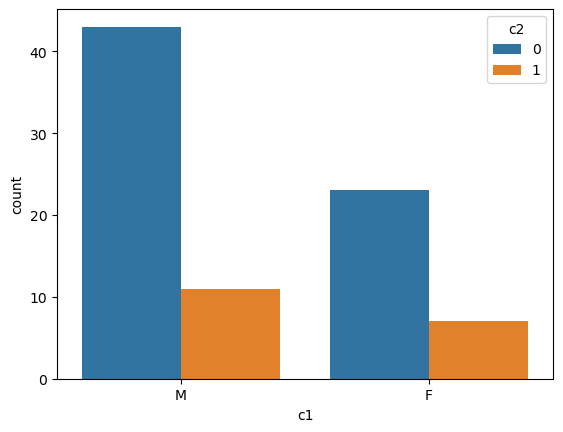

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create the dataframe
df = pd.DataFrame({
    'c1': df_test[:,0],  
    'c2': preds 
})
# Convert 'c2' column to string type
df['c2'] = df['c2'].astype(str)
# Create a countplot
sns.countplot(x='c1', hue='c2', data=df)
# Replace the x-axis labels
plt.xticks([0, 1], ['M', 'F'])

# Show the plot
plt.show()